# Comparison of different bias mitigation methods on accuracy and bias metrics

The goal of this analysis is to make a comparison of different bias mitigation methods for classification problems on different types of dataset and to see how these methods impact on different fairness metrics and on the accuracy of the classifier. The datasets on which we will test the fairness algorithms are:

1. Unbias dataset
2. Bias unbalanced dataset
3. Bias balanced dataset

In [106]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from numpy.random import default_rng
from collections import OrderedDict
sns.set_theme()

from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover, LFR

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
%matplotlib inline

In [107]:
# utility functions
def compute_dataset_fairness_metrics(data: BinaryLabelDataset, unpriv_group: list, priv_group: list):
    """ Computes: Disparate Impact and Statistical Parity """
    
    b = BinaryLabelDatasetMetric(data, unprivileged_groups=unpriv_group, privileged_groups=priv_group)
    metrics = dict()
    metrics['Disparate Impact'] = b.disparate_impact()
    metrics['Statistical Parity'] = b.statistical_parity_difference()
    for k in metrics:
        print("%s = %.4f" % (k, metrics[k]))
    return metrics

def compute_fairness_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Computes: Balanced Accuracy 
    Statistical Parity Difference
    Disparate Impact
    Average odds difference
    Equal Opportunity Difference
    Theil Index """
    
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

def build_dataset(n_samples, n_features, n_informative, n_sensitive):
    """"Builds a syntetic dataset for classification"""
    x, y = make_classification(n_samples=n_samples, 
                               n_features=n_features, 
                               n_informative=n_informative)
    data = pd.DataFrame(np.column_stack((x,y)), columns=[i for i in range(11)])
    s = np.arange(n_sensitive)
    s = np.repeat(s,n_samples/2)
    rnd = default_rng()
    rnd.shuffle(s)
    data['s'] = s
    return data

def split_data(data: BinaryLabelDataset):
    #data = BinaryLabelDataset(df=data, label_names=label_names, protected_attribute_names=protect_attr_names)
    data_train, data_tv = data.split([0.7], shuffle=True)
    data_test, data_valid = data_tv.split([0.5], shuffle=True)
    return data_train, data_test, data_valid

def x_y_split_dir(train, test):
    x_train = np.delete(train.features, train.feature_names.index('s'), axis=1)
    y_train = train.labels.ravel()
    x_test = np.delete(test.features, test.feature_names.index('s'), axis=1)
    y_test = test.labels.ravel()
    return x_train, y_train, x_test, y_test

def x_y_split(data_train: BinaryLabelDataset, data_test: BinaryLabelDataset):
    X_train = data_train.features
    Y_train = data_train.labels.ravel()
    X_test = data_test.features
    Y_test = data_test.labels.ravel()
    return X_train, Y_train, X_test, Y_test

def compute_classification_metrics(estimator, valid_data):
    
    """"Computes the bias classification metrics 
    in addition to the classification report and a confusion matrix"""
    
    pred = valid_data.copy()
    pred.labels = estimator.predict(pred.features)
    plot_classification_report(classification_report(valid_data.labels, pred.labels))
    plot_confusion_matrix(valid_data.labels, pred.labels, {'1', '0'}, normalize=True)
    class_metrics = compute_fairness_metrics(valid_data, pred, unprivileged_group, privileged_group)
    return class_metrics

def merge_datasets(datasets: dict):
    keys = list(datasets.keys())
    first_data = datasets.pop(keys[0])
    merged_metrics = pd.DataFrame(first_data, index=[0])
    merged_metrics.loc[0,'Dataset'] = keys[0]
    index = 1
    for k,v in datasets.items():
        merged_metrics = merged_metrics.append(v, ignore_index=True)
        merged_metrics.loc[index,'Dataset'] = k
        index = index + 1
    merged_data = merged_metrics.melt(id_vars='Dataset', value_name='values', var_name='metrics')
    return merged_data

In [108]:
# plot functions

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

def plot_metrics_comparison(bias_class_metrics, rw_class_metrics, title1='', title2=''):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    keys = list(bias_class_metrics.keys())
    vals = [float(bias_class_metrics[k]) for k in keys]
    sns.barplot(x=keys, y=vals,ax=ax[0])
    for k in keys:
        ax[0].text(keys.index(k), 
                   bias_class_metrics[k], 
                   round(bias_class_metrics[k], 3), 
                   ha="center",
                   va="bottom",
                   fontsize="medium"
                  )
    keys = list(rw_class_metrics.keys())
    vals = [float(rw_class_metrics[k]) for k in keys]
    sns.barplot(x=keys, y=vals,ax=ax[1])
    for k in keys:
        ax[1].text(keys.index(k), 
                   rw_class_metrics[k], 
                   round(rw_class_metrics[k], 3), 
                   ha="center",
                   va="bottom",
                   fontsize="medium"
                  )
    ax[0].tick_params(labelrotation=90)
    ax[0].set(title=title1)
    ax[1].tick_params(labelrotation=90)
    ax[1].set(title=title2)
    return ax

def plot_syntesis(dataset, title):
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    unbias_fig = sns.barplot(data = dataset, x='metrics', y='values', hue='Dataset', ax=ax)
    plt.ylabel(ylabel='')
    plt.xlabel(xlabel='')
    plt.title(title)
    return ax

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the target variable at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the target variable $y$ are changed s.t. the mean of the $y$ distribution is the mean between the mean of $y$ distribution for the privileged and unprivileged groups. 
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier. 

<!--3. **LFR**

> Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes-->

## Dataset creation

Here we will create a binary labeled dataset with 10.000 samples and 11 features of which 4 are informative features and one will act as sensitive attribute:

In [109]:
n_samples = 10000
n_features = 10
n_informative = 4
n_sensitive = 2

In [110]:
data = build_dataset(n_samples, n_features, n_informative, n_sensitive)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,s
0,1.713671,1.318003,3.314570,-2.412961,-0.032171,1.279579,-1.347549,0.755061,-3.022456,1.119930,0.0,1
1,-1.859067,-1.478354,-0.205743,-0.185225,-0.623304,2.985101,0.792430,-1.354996,-0.913581,1.203007,0.0,1
2,-0.881762,-0.693225,0.828340,0.922132,-0.125016,1.766073,-1.455644,1.143491,-1.531026,-1.142962,0.0,0
3,1.584475,-1.881815,1.064806,1.251965,0.066138,-2.223934,0.623487,0.818353,0.231112,-1.355751,1.0,0
4,-0.591757,-0.265490,1.104522,-0.038591,-0.410139,1.943131,-0.434716,0.754354,-2.262309,-1.723527,0.0,0


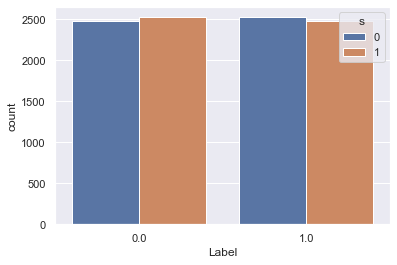

In [111]:
ax = sns.barplot(
    x=10, y='count', 
    hue='s', 
    data=data.groupby('s')[10].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

The dataset seems to be fair with respect to the sensitive attribute

In [112]:
unprivileged_group = [{'s': 0}]
privileged_group = [{'s': 1}]

# Unbias dataset

Here we will apply the metrics and the algorithms defined above on the unbias version of the dataset and compare how these bias mitigation algorithms change the different metrics.

## Dataset fairness metrics 

Let's compute the dataset fairness metrics defined above on the syntetic dataset to check that it is really unbias

In [113]:
bin_data = BinaryLabelDataset(df=data, label_names=[10], protected_attribute_names=['s'])
fair_data_train, fair_data_test, fair_data_valid = split_data(bin_data)
metrics = compute_dataset_fairness_metrics(fair_data_train, unprivileged_group, privileged_group)

Disparate Impact = 0.9966
Statistical Parity = -0.0017


The dataset is not bias.

## Classification bias metrics

Here we train and test a _Logistic Regression_ classifier:

In [114]:
X_train, Y_train, X_test, Y_test = x_y_split(fair_data_train, fair_data_test)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe_fit = pipe.fit(X_train, Y_train, logisticregression__sample_weight=fair_data_train.instance_weights.ravel())
score = cross_val_score(pipe_fit, X_test, Y_test)
print("Accuracy: %f"% np.mean(score))

Accuracy: 0.761333


Balanced accuracy = 0.7741
Statistical parity difference = 0.0323
Disparate impact = 1.0677
Average odds difference = 0.0130
Equal opportunity difference = -0.0128
Theil index = 0.1625


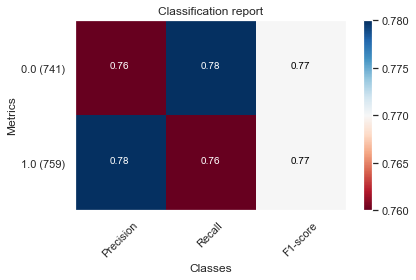

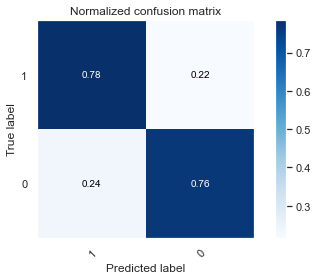

In [115]:
class_metrics = compute_classification_metrics(pipe_fit, fair_data_valid)
plt.show()

From the values of the metrics we can see that the classifier is fair and quite accurate. Let's now test the same metrics on a bias dataset.

## Reweighing

Here we apply the _Reweighing_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [116]:
rw_unbias_data = bin_data.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
rw_unbias_data = rw.fit_transform(rw_unbias_data)

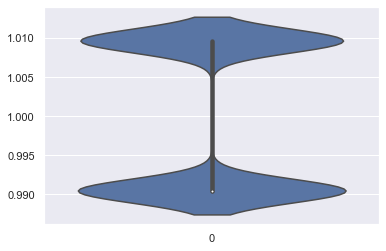

In [117]:
sns.violinplot(data=rw_unbias_data.instance_weights)
plt.show()

### Dataset metrics

In [118]:
metrics = compute_dataset_fairness_metrics(rw_unbias_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification metrics

In [119]:
rw_un_train, rw_un_test, rw_un_valid = split_data(rw_unbias_data)
x_train, y_train, x_test, y_test = x_y_split(rw_un_train, rw_un_test)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe = pipe.fit(x_train, y_train, logisticregression__sample_weight=rw_un_train.instance_weights.ravel())
score = cross_val_score(pipe, x_test, y_test, fit_params={"logisticregression__sample_weight": rw_un_test.instance_weights.ravel()})
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.782667


Balanced accuracy = 0.7753
Statistical parity difference = 0.0134
Disparate impact = 1.0254
Average odds difference = 0.0165
Equal opportunity difference = 0.0202
Theil index = 0.1400


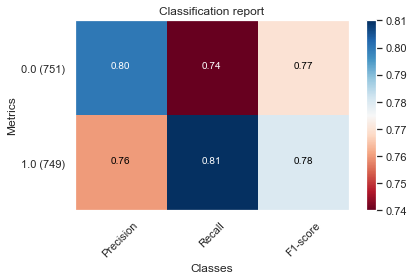

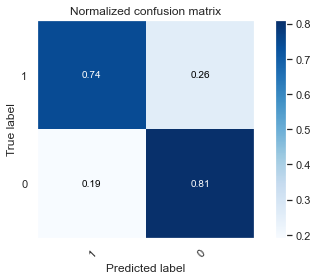

In [120]:
#rw_un_valid.features = np.delete(rw_un_valid.features, rw_un_valid.feature_names.index('s'), axis=1)
rw_un_metrics = compute_classification_metrics(pipe, rw_un_valid)
plt.show()

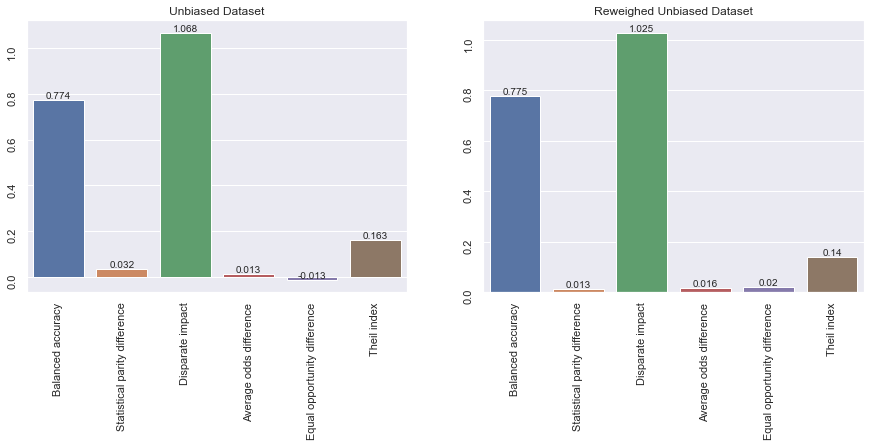

In [121]:
plot_metrics_comparison(class_metrics, rw_un_metrics, "Unbiased Dataset", "Reweighed Unbiased Dataset")
plt.show()

## Disparate Impact Remover

Here we apply the _Disparate Impact Remover_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [122]:
dir_unb_data = bin_data.copy(deepcopy=True)
scaler = MinMaxScaler(copy=False)
dir_unb_data.features = scaler.fit_transform(dir_unb_data.features)

In [123]:
di = DisparateImpactRemover(sensitive_attribute='s')
dir_unb_data = di.fit_transform(dir_unb_data)

### Dataset metrics

In [124]:
metrics = compute_dataset_fairness_metrics(dir_unb_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0194
Statistical Parity = 0.0096


### Classification metrics

In [125]:
train_dir_un, test_dir_un, valid_dir_un = split_data(dir_unb_data)
#x_train, y_train, x_test, y_test = x_y_split(train_dir_un, test_dir_un)
x_train = np.delete(train_dir_un.features, train_dir_un.feature_names.index('s'), axis=1)
y_train = train_dir_un.labels.ravel()
x_test = np.delete(test_dir_un.features, test_dir_un.feature_names.index('s'), axis=1)
y_test = test_dir_un.labels.ravel()
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe = pipe.fit(x_train, y_train, logisticregression__sample_weight=train_dir_un.instance_weights.ravel())
score = cross_val_score(pipe, x_test, y_test, fit_params={"logisticregression__sample_weight": test_dir_un.instance_weights.ravel()})
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.788000


Balanced accuracy = 0.7822
Statistical parity difference = -0.0174
Disparate impact = 0.9659
Average odds difference = -0.0215
Equal opportunity difference = 0.0083
Theil index = 0.1453


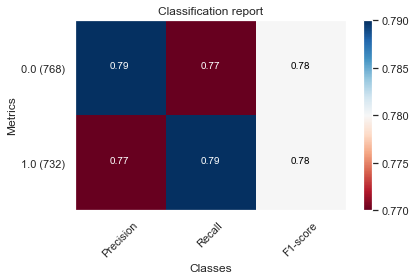

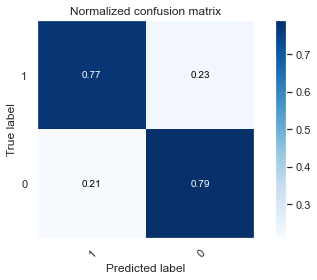

In [126]:
valid_dir_un.features = np.delete(valid_dir_un.features, valid_dir_un.feature_names.index('s'), axis=1)
dir_fair_metrics = compute_classification_metrics(pipe, valid_dir_un)

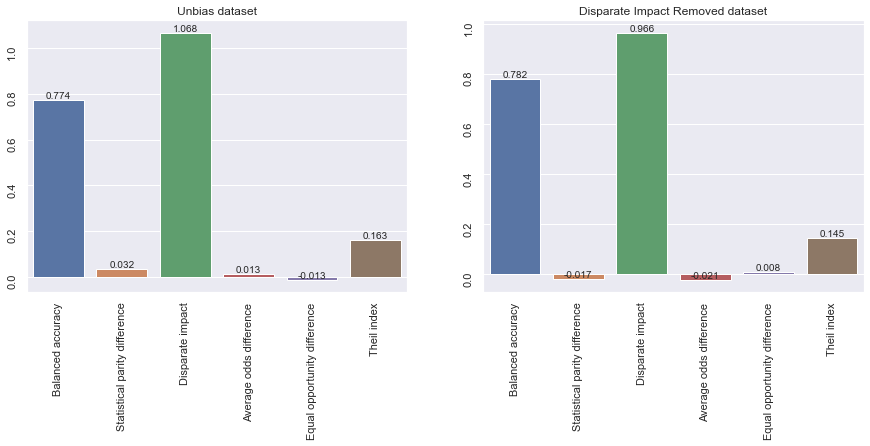

In [127]:
plot_metrics_comparison(class_metrics, dir_fair_metrics, "Unbias dataset", "Disparate Impact Removed dataset")
plt.show()

## Reweighing vs Disparate Impact Remover

In the following we compare the performances of _Reweighing_ and _Disparate Impact Remover_ on the unbias dataset. 

In [128]:
un_merged_metrics = merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Disparate Impact Removed': dir_fair_metrics
})

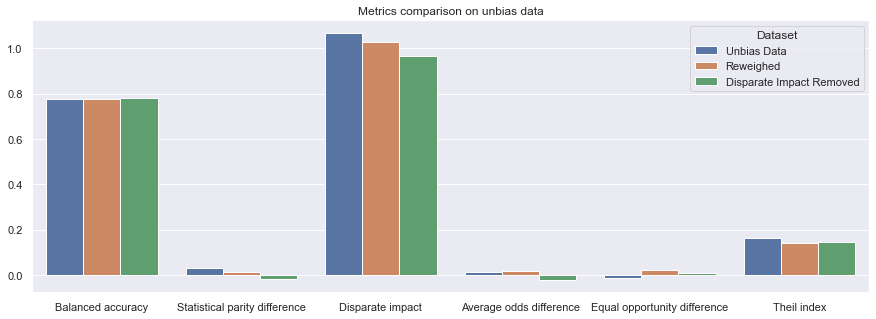

In [129]:
plot_syntesis(un_merged_metrics, 'Metrics comparison on unbias data')
plt.show()

# Unbalanced Bias dataset

Let's change the previous dataset adding a bias on the sensitive attribute `s` with value 0 and keeping the instances with `s=1` invariate:

In [130]:
bias_data = data.copy(deep=True)
bias_data.loc[(bias_data['s'] == 0) & (bias_data.index < int(n_samples/2)) , 10] = 0.0

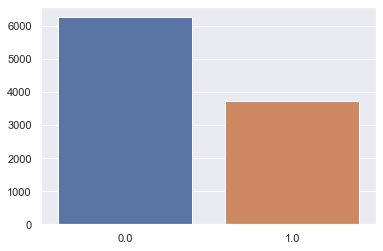

In [131]:
sns.barplot(x=bias_data[10].value_counts().index, y=bias_data[10].value_counts().values)
plt.show()

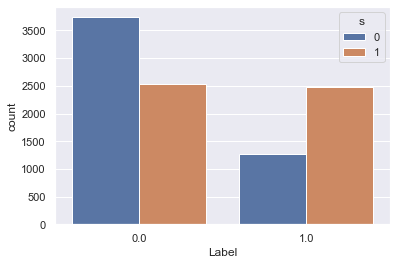

In [132]:
ax = sns.barplot(
    x=10, y='count', 
    hue='s', 
    data=bias_data.groupby('s')[10].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

## Dataset fairness metrics

Let's compute the dataset fairness metrics on this new dataset:

In [133]:
bias_data_bin = BinaryLabelDataset(df = bias_data, label_names=[10], protected_attribute_names=['s'])
bias_metrics = compute_dataset_fairness_metrics(bias_data_bin, unprivileged_group, privileged_group)

Disparate Impact = 0.5095
Statistical Parity = -0.2428


## Classification bias metrics

In [134]:
bias_train, bias_test, bias_valid = split_data(bias_data_bin)

In [135]:
x_train, y_train, x_test, y_test = x_y_split(bias_train, bias_test)
bias_pipe = make_pipeline(StandardScaler(), LogisticRegression())
bias_pipe_fit = bias_pipe.fit(
    x_train, y_train, logisticregression__sample_weight=bias_train.instance_weights.ravel())
bias_accuracy = cross_val_score(bias_pipe_fit, x_test, y_test)
print("Accuracy: %f" % np.mean(bias_accuracy))

Accuracy: 0.770000


Balanced accuracy = 0.7169
Statistical parity difference = -0.3750
Disparate impact = 0.2266
Average odds difference = -0.3609
Equal opportunity difference = -0.5996
Theil index = 0.2058


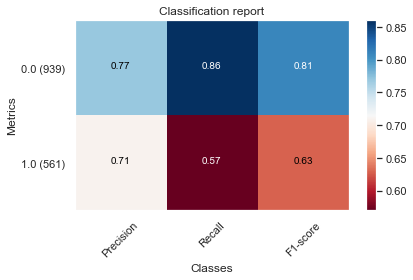

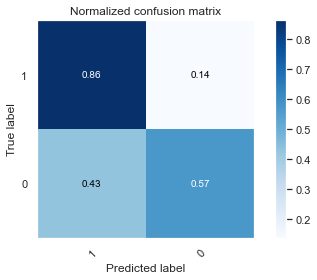

In [136]:
bias_class_metrics = compute_classification_metrics(bias_pipe_fit, bias_valid)

##  Reweighing

In [137]:
rw_data = bias_data_bin.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
rw_data = rw.fit_transform(rw_data)

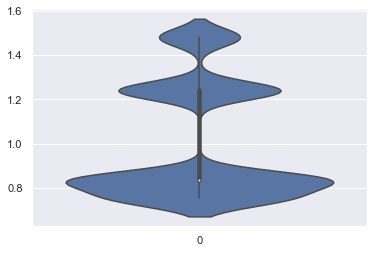

In [138]:
sns.violinplot(data=rw_data.instance_weights)
plt.show()

### Dataset metrics

In [139]:
rw_metrics = compute_dataset_fairness_metrics(rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = -0.0000


### Classification metrics

In [140]:
rw_train, rw_test, rw_valid = split_data(rw_data)
x_train, y_train, x_test, y_test = x_y_split(rw_train, rw_test)

In [141]:
rw_pipeline = make_pipeline(StandardScaler(), LogisticRegression())
rw_pipeline.fit(x_train, y_train, logisticregression__sample_weight=rw_train.instance_weights.ravel())
score = cross_val_score(
    rw_pipeline, x_test, y_test, 
    fit_params={"logisticregression__sample_weight": rw_test.instance_weights.ravel()}
)
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.728667


Balanced accuracy = 0.6782
Statistical parity difference = -0.0247
Disparate impact = 0.9256
Average odds difference = -0.0567
Equal opportunity difference = -0.1853
Theil index = 0.2187


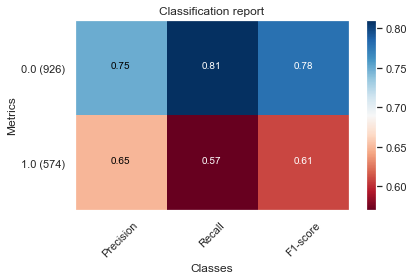

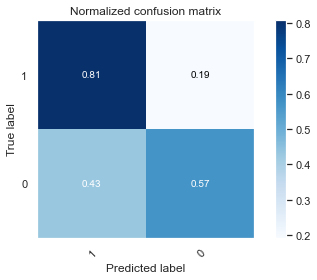

In [142]:
#rw_valid.features = np.delete(rw_valid.features, rw_valid.feature_names.index('s'), axis=1)
rw_class_metrics = compute_classification_metrics(rw_pipeline, rw_valid)

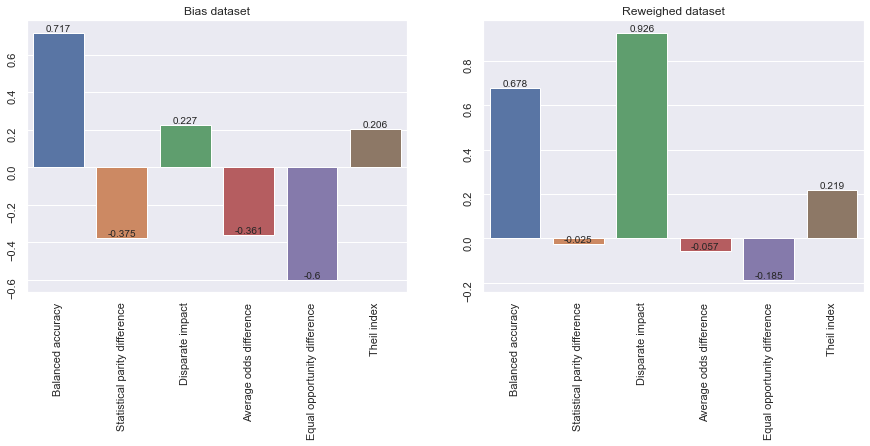

In [143]:
plot_metrics_comparison(bias_class_metrics, rw_class_metrics, "Bias dataset", "Reweighed dataset")
plt.show()

## Disparate Impact Remover

In [144]:
dir_data = bias_data_bin.copy(deepcopy=True)
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

In [145]:
dr = DisparateImpactRemover(sensitive_attribute='s')
dir_data = dr.fit_transform(dir_data)

### Dataset metrics

In [146]:
dir_metrics = compute_dataset_fairness_metrics(dir_data, unprivileged_group, privileged_group)

Disparate Impact = 0.5095
Statistical Parity = -0.2428


### Classification metrics

In [147]:
dir_train, dir_test, dir_valid = split_data(dir_data)

In [148]:
x_train = np.delete(dir_train.features, dir_train.feature_names.index('s'), axis=1)
y_train = dir_train.labels.ravel()
x_test = np.delete(dir_test.features, dir_test.feature_names.index('s'), axis=1)
y_test = dir_test.labels.ravel()

In [149]:
dr_pipe = make_pipeline(StandardScaler(), LogisticRegression())
dr_pipe.fit(x_train, y_train)
score = cross_val_score(dr_pipe, x_test, y_test)
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.694000


Balanced accuracy = 0.6694
Statistical parity difference = -0.0122
Disparate impact = 0.9589
Average odds difference = 0.0437
Equal opportunity difference = -0.0489
Theil index = 0.2379


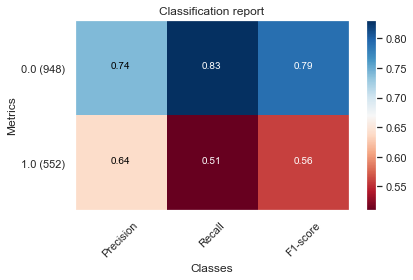

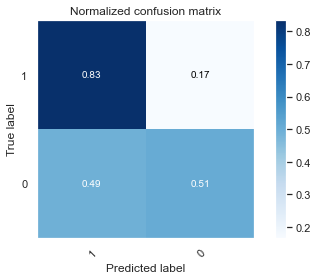

In [150]:
dir_valid_final = dir_valid.copy()
dir_valid_final.features = np.delete(dir_valid.features, dir_valid.feature_names.index('s'), axis=1)
dir_class_metrics = compute_classification_metrics(dr_pipe, dir_valid_final)

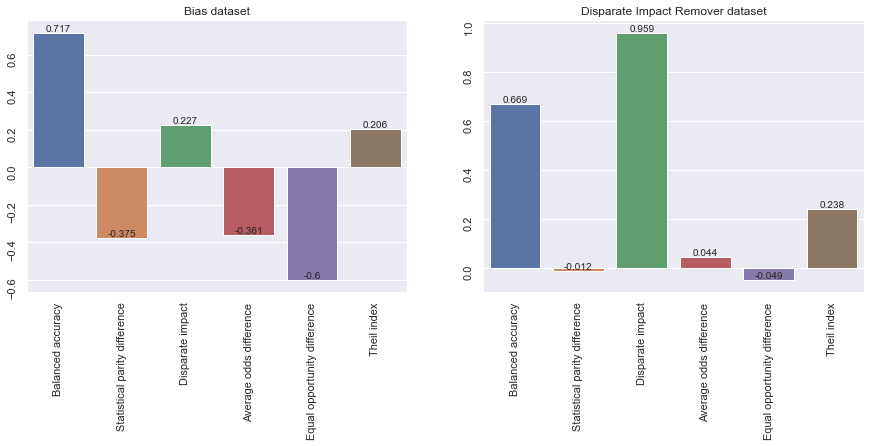

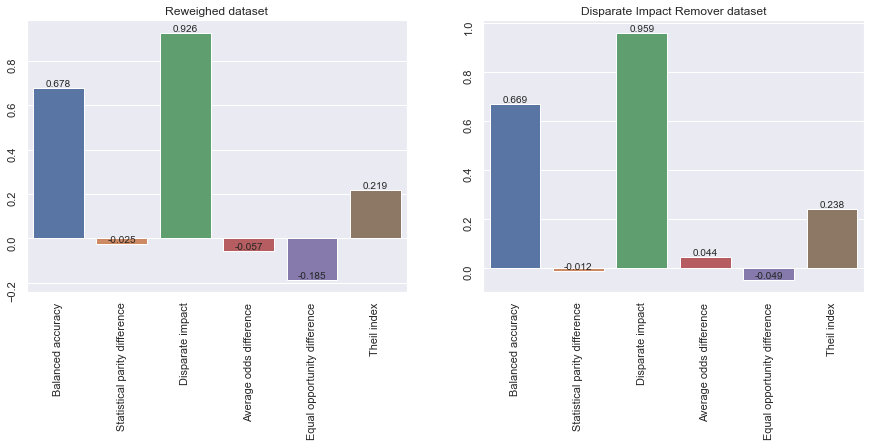

In [151]:
plot_metrics_comparison(bias_class_metrics, dir_class_metrics, "Bias dataset", "Disparate Impact Remover dataset")
plot_metrics_comparison(rw_class_metrics, dir_class_metrics, "Reweighed dataset", "Disparate Impact Remover dataset")
plt.show()

## Reweighing vs Disparate Impact Remover

In [152]:
unbal_merged_metrics = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Disparate Impact Removed': dir_class_metrics
})

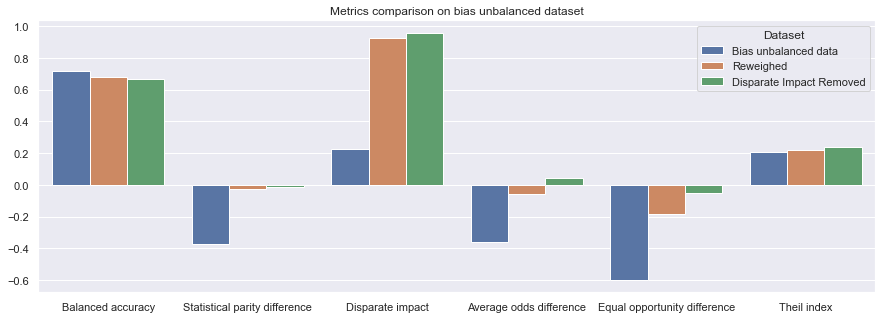

In [153]:
plot_syntesis(unbal_merged_metrics, 'Metrics comparison on bias unbalanced dataset')
plt.show()

# Bias balanced dataset

Let's balance the previous dataset changing the labels of half of the samples with `s=1` to `1.0`

In [154]:
bias_bal_data = bias_data.copy(deep=True)
bias_bal_data.loc[(bias_data['s'] == 1) & (bias_data.index < int(n_samples/2)) & (bias_data[10]==0.0) , 10] = 1.0

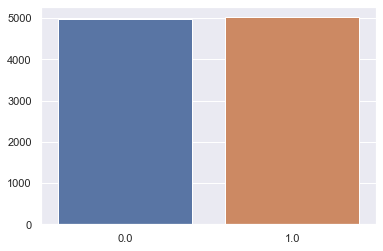

In [155]:
sns.barplot(x=bias_bal_data[10].value_counts().index, y=bias_bal_data[10].value_counts().values)
plt.show()

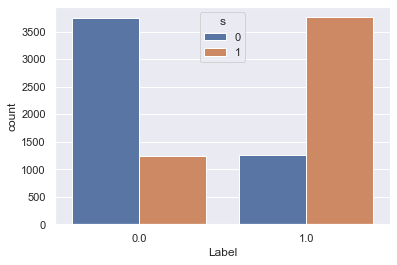

In [156]:
ax = sns.barplot(
    x=10, y='count', 
    hue='s', 
    data=bias_bal_data.groupby('s')[10].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

In [157]:
bias_bal_bin = BinaryLabelDataset(df=bias_bal_data, label_names=[10], protected_attribute_names=['s'])

## Dataset metrics

In [158]:
bal_metrics = compute_dataset_fairness_metrics(bias_bal_bin, unprivileged_group, privileged_group)

Disparate Impact = 0.3354
Statistical Parity = -0.4998


## Classification metrics

In [159]:
train, test, valid = split_data(bias_bal_bin)

In [160]:
x_train, y_train, x_test, y_test = x_y_split(train, test)

In [161]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train)
score = cross_val_score(pipe, x_test, y_test)
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.737333


Balanced accuracy = 0.7660
Statistical parity difference = -0.8507
Disparate impact = 0.0772
Average odds difference = -0.7867
Equal opportunity difference = -0.8018
Theil index = 0.1606


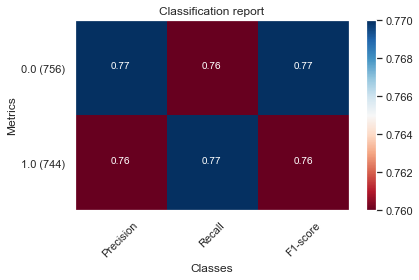

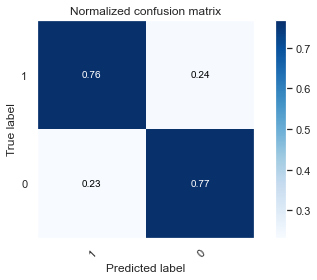

In [162]:
bias_bal_metrics = compute_classification_metrics(pipe, valid)

## Reweighing

In [163]:
rw_bal = bias_bal_bin.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
rw_bal = rw.fit_transform(rw_bal)

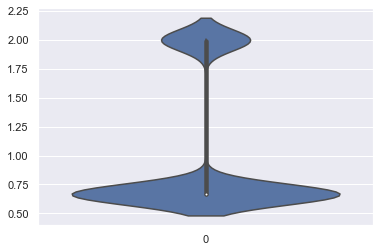

In [164]:
sns.violinplot(data=rw_bal.instance_weights)
plt.show()

### Dataset metrics

In [165]:
rw_metrics = compute_dataset_fairness_metrics(rw_bal, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification metrics

In [166]:
rw_train, rw_test, rw_valid = split_data(rw_bal)

In [167]:
x_train, y_train, x_test, y_test = x_y_split(rw_train, rw_test)

In [168]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train, logisticregression__sample_weight=rw_train.instance_weights.ravel())
score = cross_val_score(pipe, x_test, y_test, 
                        fit_params={"logisticregression__sample_weight": rw_test.instance_weights.ravel()})
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.660667


Balanced accuracy = 0.6838
Statistical parity difference = 0.0122
Disparate impact = 1.0262
Average odds difference = 0.0251
Equal opportunity difference = -0.0087
Theil index = 0.2357


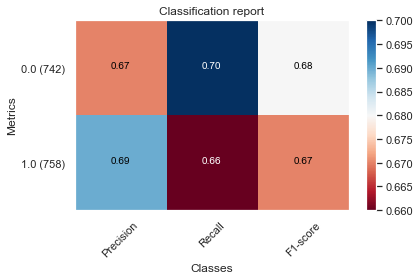

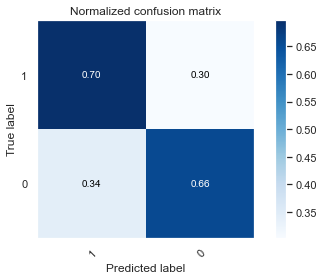

In [169]:
rw_metrics = compute_classification_metrics(pipe, rw_valid)

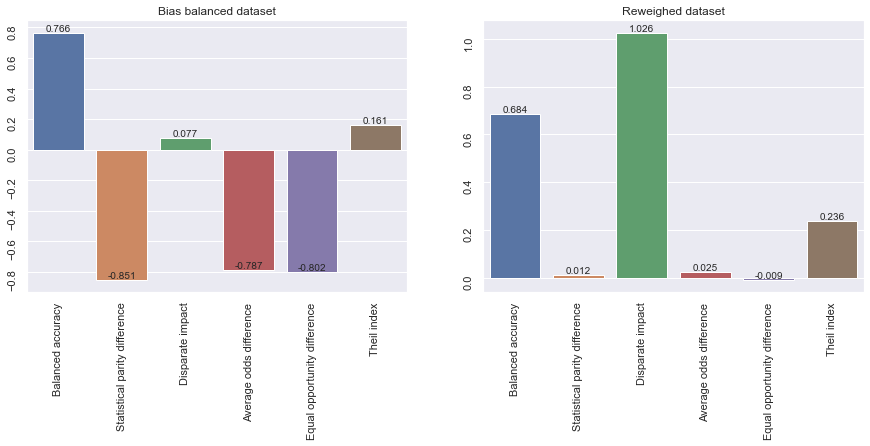

In [170]:
plot_metrics_comparison(bias_bal_metrics, rw_metrics, 'Bias balanced dataset', 'Reweighed dataset')
plt.show()

## Disparate Impact Remover

In [171]:
dir_bal = bias_bal_bin.copy(deepcopy=True)
scaler = MinMaxScaler()
dir_bal.features = scaler.fit_transform(dir_bal.features)
dr = DisparateImpactRemover(sensitive_attribute='s')
dir_bal = dr.fit_transform(dir_bal)

### Dataset metrics

In [172]:
dir_metrics = compute_dataset_fairness_metrics(dir_bal, unprivileged_group, privileged_group)

Disparate Impact = 0.3354
Statistical Parity = -0.4998


### Classification metrics

In [173]:
train, test, valid = split_data(dir_bal)

In [174]:
x_train, y_train, x_test, y_test = x_y_split_dir(train, test)

In [175]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train)
score = cross_val_score(pipe, x_test, y_test)
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.612000


Balanced accuracy = 0.6522
Statistical parity difference = -0.0294
Disparate impact = 0.9448
Average odds difference = 0.1711
Equal opportunity difference = 0.1600
Theil index = 0.2411


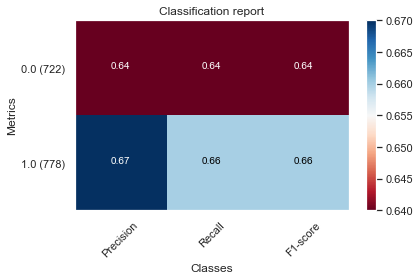

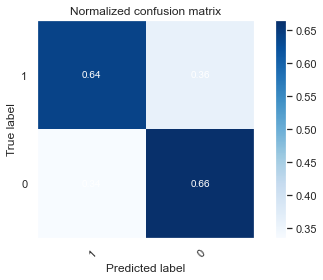

In [176]:
valid_copy = valid.copy()
valid_copy.features = np.delete(valid.features, valid.feature_names.index('s'), axis=1)
dir_score = compute_classification_metrics(pipe, valid_copy)

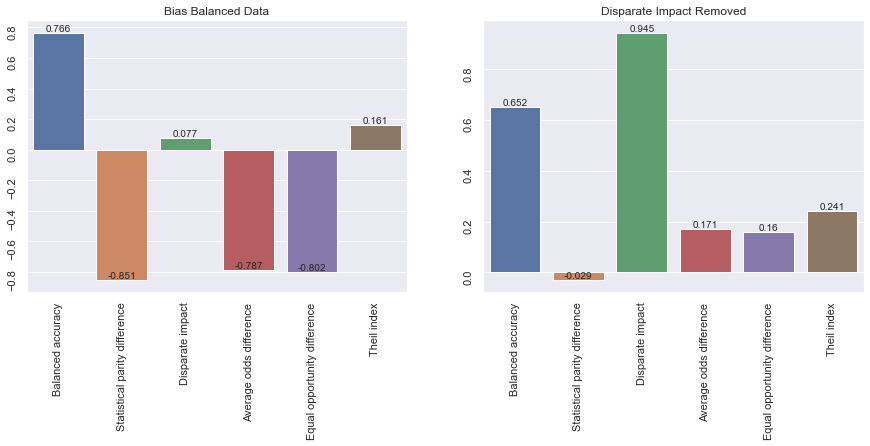

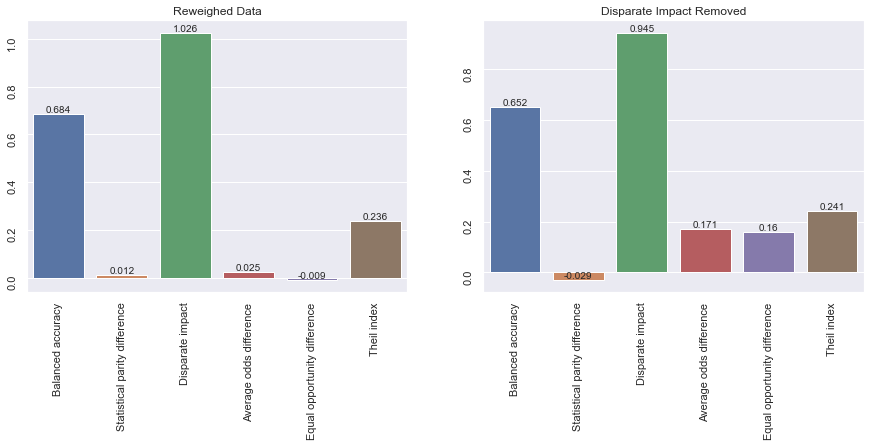

In [177]:
plot_metrics_comparison(bias_bal_metrics, dir_score, 'Bias Balanced Data', 'Disparate Impact Removed')
plot_metrics_comparison(rw_metrics, dir_score, 'Reweighed Data', 'Disparate Impact Removed')
plt.show()

## Reweighing vs Disparate Impact Remover

In [178]:
bal_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Disparate Impact Removed': dir_score
})

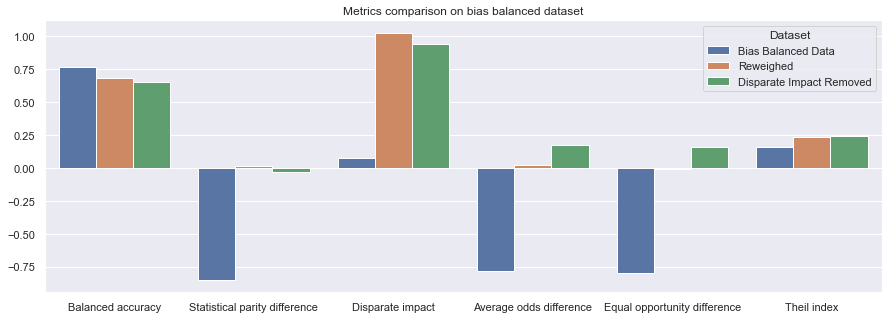

In [179]:
plot_syntesis(bal_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()

# Comparison of the three datasets

Here we compare the metrics for the three versions of the dataset and the methods applied:

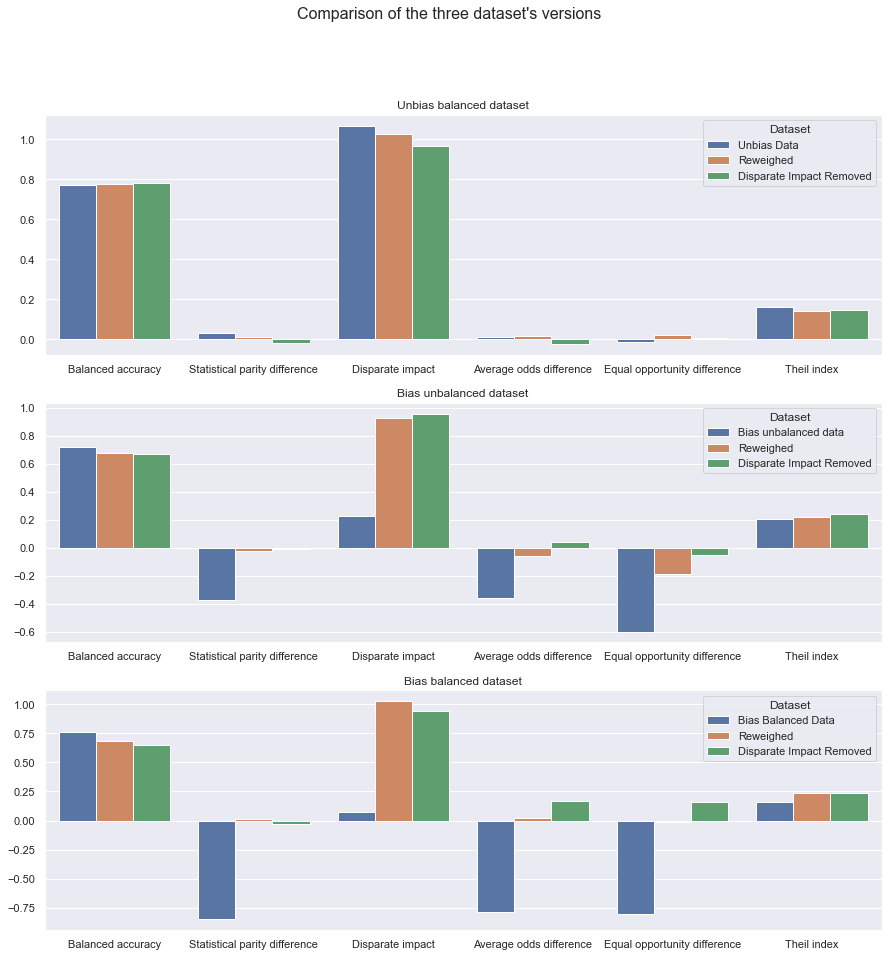

In [180]:
fig, axes = plt.subplots(3,1,figsize=(15,15))
sns.barplot(data=un_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[0],)
sns.barplot(data=unbal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[1])
sns.barplot(data=bal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[2])
for ax in axes:
    ax.set(xlabel='', ylabel='')
axes[0].set_title('Unbias balanced dataset')
axes[1].set_title('Bias unbalanced dataset')
axes[2].set_title('Bias balanced dataset')
fig.suptitle("Comparison of the three dataset's versions", fontsize=16)
plt.show()

# Combine Reweighing and DIR

As can be seen from the charts above both RW and DIR performs well in mitigating the unfairness of the classifier. However both have some lacks:

1. Reweighing requires that a classifier takes account of instance weights, but not all the classifier models do so
2. Disparate Impact Remover has no effect on the dataset fairness metrics but only on the classifier metrics

To solve these problems we will now try to combine these two algorithms by applying the instance weights to the DIR modified dataset and see the results.

## Test with unbias data

In [181]:
un_rw_dir = dir_unb_data.copy(deepcopy=True)
un_rw_dir.instance_weights = rw_unbias_data.instance_weights

In [182]:
score = compute_dataset_fairness_metrics(un_rw_dir, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


In [183]:
train, test, val = split_data(un_rw_dir)

In [184]:
x_train, y_train, x_test, y_test = x_y_split_dir(train, test)

In [185]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train, logisticregression__sample_weight=train.instance_weights.ravel())
score = cross_val_score(pipe, x_test, y_test, 
                        fit_params={"logisticregression__sample_weight": test.instance_weights.ravel()})
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.762667


Balanced accuracy = 0.7767
Statistical parity difference = -0.0030
Disparate impact = 0.9940
Average odds difference = -0.0072
Equal opportunity difference = 0.0029
Theil index = 0.1545


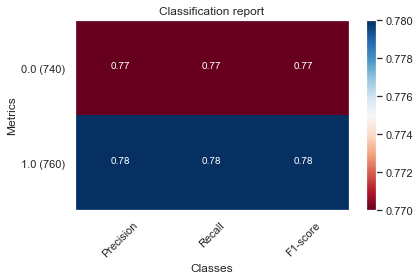

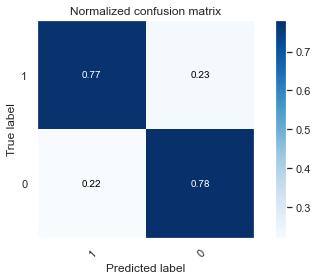

In [186]:
val_c = val.copy()
val_c.features = np.delete(val_c.features, val_c.feature_names.index('s'), axis=1)
unb_rw_dir_score = compute_classification_metrics(pipe, val_c)

In [187]:
un_rw_dir_merg =  merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Disparate Impact Removed': dir_fair_metrics,
    'RW + DIR': unb_rw_dir_score
})

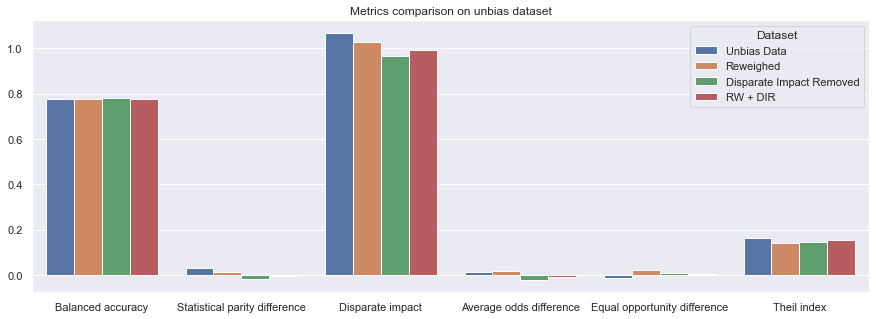

In [188]:
plot_syntesis(un_rw_dir_merg, 'Metrics comparison on unbias dataset')
plt.show()

## Test with unbalance bias data

In [189]:
unbal_dir_rw_data = dir_data.copy()
unbal_dir_rw_data.instance_weights = rw_data.instance_weights

In [190]:
score = compute_dataset_fairness_metrics(unbal_dir_rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = -0.0000


In [191]:
train, test, val = split_data(unbal_dir_rw_data)

In [192]:
x_train, y_train, x_test, y_test = x_y_split_dir(train ,test)

In [193]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train, logisticregression__sample_weight=train.instance_weights.ravel())
score = cross_val_score(pipe, x_test, y_test, 
                        fit_params={"logisticregression__sample_weight": test.instance_weights.ravel()})
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.702667


Balanced accuracy = 0.6647
Statistical parity difference = 0.0762
Disparate impact = 1.2732
Average odds difference = 0.0549
Equal opportunity difference = -0.0229
Theil index = 0.2456


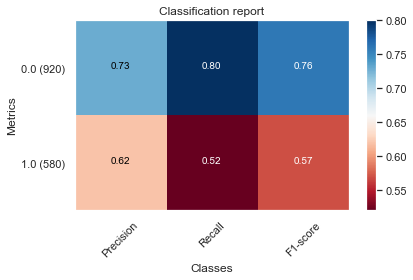

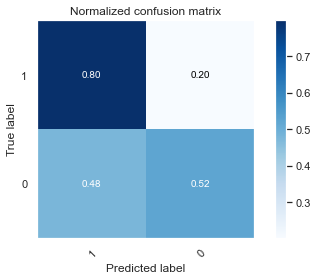

In [194]:
val_c = val.copy()
val_c.features = np.delete(val_c.features, val_c.feature_names.index('s'), axis=1)
rw_dir_score = compute_classification_metrics(pipe, val_c)

In [195]:
unbal_rw_dir_score = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Disparate Impact Removed': dir_class_metrics,
    'RW + DIR': rw_dir_score
})

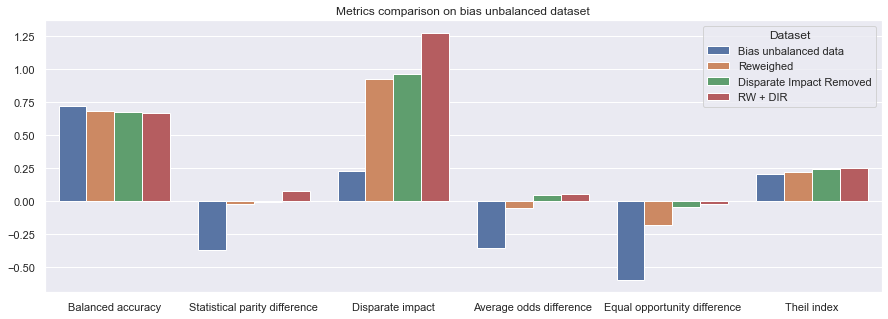

In [196]:
plot_syntesis(unbal_rw_dir_score, 'Metrics comparison on bias unbalanced dataset')
plt.show()

## Test with balanced bias data

In [197]:
dir_rw_data = dir_bal.copy()
dir_rw_data.instance_weights = rw_bal.instance_weights

In [198]:
score = compute_dataset_fairness_metrics(dir_rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


In [199]:
train, test, val = split_data(dir_rw_data)

In [200]:
x_train, y_train, x_test, y_test = x_y_split_dir(train, test)

In [201]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train, logisticregression__sample_weight=train.instance_weights.ravel())
score = cross_val_score(pipe, x_test, y_test, 
                        fit_params={"logisticregression__sample_weight": test.instance_weights.ravel()})
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.656000


Balanced accuracy = 0.6907
Statistical parity difference = 0.2138
Disparate impact = 1.4995
Average odds difference = 0.2174
Equal opportunity difference = 0.2278
Theil index = 0.2337


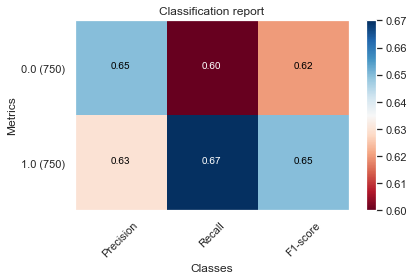

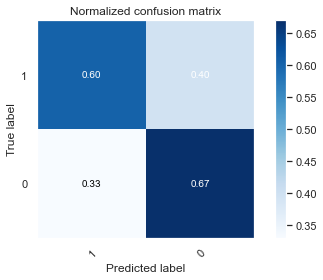

In [202]:
val_c = val.copy()
val_c.features = np.delete(val_c.features, val_c.feature_names.index('s'), axis=1)
rw_dir_score = compute_classification_metrics(pipe, val_c)

In [203]:
rw_dir_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Disparate Impact Removed': dir_score,
    'RW + DIR': rw_dir_score
})

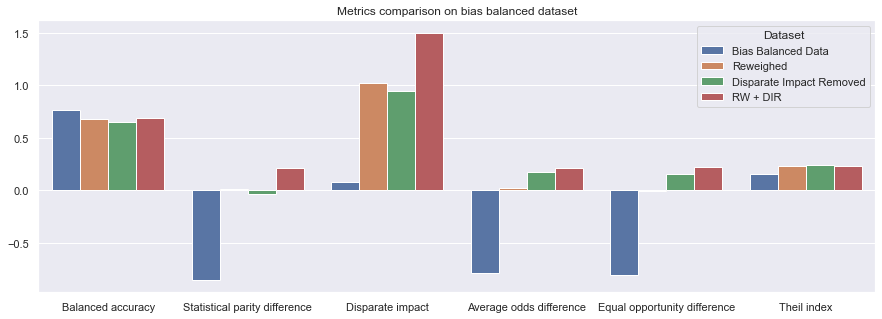

In [204]:
plot_syntesis(rw_dir_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()